# Creating an Amundsen Sea Low (ASL) index

This work is a continuation of my 2013 and 2016 papers as described [here](https://legacy.bas.ac.uk/data/absl/)

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from skimage.feature import peak_local_max

## Read in gridded monthly mean data for period 1979-2018

In [2]:
ds   = xr.open_dataset('~/Desktop/era5_mean_sea_level_pressure_monthly.nc')
mask = xr.open_dataset('~/DATA/ERAI/erai_invariant.nc').lsm.squeeze()

In [3]:
da = ds.msl

## Apply land-sea mask

In [4]:
da_mask = da.where(mask == 0)
da_mask.mean().values, da.mean().values # these are different, great!

(array(58826.84375), array(38953.96875))

In [5]:
da = da.sel(latitude=slice(-55,-90))

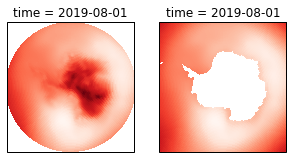

In [7]:
plt.figure(figsize=(5,5))
ax1 = plt.subplot( 121, projection=ccrs.Stereographic(central_longitude=0., central_latitude=-90.) )
ax1.set_extent([-180,180,-90,-55], ccrs.PlateCarree())
da.isel(time=-1).plot.pcolormesh( 'longitude', 'latitude', cmap='Reds', 
                                        transform=ccrs.PlateCarree(), add_colorbar=False )

ax2 = plt.subplot( 122, projection=ccrs.Stereographic(central_longitude=0., central_latitude=-90.) )
ax2.set_extent([-180,180,-90,-55], ccrs.PlateCarree())
da_mask.isel(time=-1).plot.pcolormesh( 'longitude', 'latitude', cmap='Reds', 
                                        transform=ccrs.PlateCarree(), add_colorbar=False )


## Definitions to identify areas of low pressure

In [8]:
def get_lows(da, threshold=None):
    
    invert_data = (da*-1.).values     # search for peaks rather than minima
    
    if threshold is None:
        threshold_abs = invert_data.mean()
    else:
        threshold_abs  = threshold * -1  # define threshold cut-off for peaks (inverted lows)
                
    minima_yx = peak_local_max(invert_data,            # input data
                           min_distance=1,             # peaks are separated by at least min_distance
                           num_peaks=6,                # maximum number of peaks
                           exclude_border=True,        # excludes peaks from within min_distance - pixels of the border
                           threshold_abs=threshold_abs # minimum intensity of peaks
                           )
    return minima_yx



def sector_mean(da, dict):
    a = da.sel( latitude=slice(asl_region['north'],asl_region['south']), 
                longitude=slice(asl_region['west'],asl_region['east']) ).mean()
    return a



def get_asl(da, region, mask):
    '''
    da for one point in time (with lats x lons)
    '''
    
    lons, lats = da.longitude.values, da.latitude.values
    
    threshold = da.sel( latitude=slice(region['north'], region['south']), 
                        longitude=slice(region['west'], region['east']) ).mean().values

    time_str = str(da.time.values)[:10]
    sec_pres = sector_mean(da.where(mask == 0), region).values
    
    # fill land in with highest value to limit lows being found here
    da_max   = da.max().values
    da       = da.where(mask == 0).fillna(da_max)
    
    ### get lows for entire domain
    minima_yx = get_lows(da, threshold)
    
    minima_lat, minima_lon, pressure = [], [], []
    for minima in minima_yx:
        minima_lat.append(lats[minima[0]])
        minima_lon.append(lons[minima[1]])
        pressure.append(da.values[minima[0],minima[1]])
    
    df = pd.DataFrame()
    df['lat']      = minima_lat
    df['lon']      = minima_lon
    df['pressure'] = pressure
    df['ASL_Sector_Pres'] = sec_pres
    df['time']     = time_str
    
    ### select only those points within ASL box
    asl_df = df[(df['lon'] > region['west'])  & 
                (df['lon'] < region['east'])  & 
                (df['lat'] > region['south']) & 
                (df['lat'] < region['north']) ]

    ### For each time, get the row with the lowest minima_number
    asl_df = asl_df.loc[asl_df.groupby('time')['pressure'].idxmin()]
    
    return asl_df

## Define area we are interested in

In [9]:
asl_region = {'west':170., 'east':298., 'south':-80., 'north':-60.}

## Loop through all times and identify lows
record these data in a Pandas DataFrame

In [10]:
ntime      = da.time.shape[0]

all_lows_df = pd.DataFrame()
asl_df      = pd.DataFrame()

for t in range(0,ntime):
    da_t   = da.isel(time=t) / 100.
    asl_df = pd.concat([asl_df, get_asl(da_t, asl_region, mask)]).reset_index(drop=True)

### Show the last 7 rows

In [15]:
asl_df.iloc[-7:]

,lat,lon,pressure,ASL_Sector_Pres,time
457,-64.50,175.50,979.433777,985.535889,2019-01-01
458,-69.75,237.75,976.678284,983.035889,2019-03-01
459,-71.25,218.25,968.650452,979.597046,2019-04-01
460,-66.75,216.75,971.407349,980.768860,2019-05-01
461,-75.75,202.50,968.992004,981.884888,2019-06-01
462,-72.75,229.50,977.848511,987.371704,2019-07-01
463,-71.25,194.25,972.841553,986.509766,2019-08-01


In [12]:
asl_df.to_csv('asli_v3_era-interim.csv', index=False)

# Plotting: location of minimas in pressure field

In [13]:
def draw_regional_box( region, transform=None ):
    '''
    Draw box around a region on a map
    region is a dictionary with west,east,south,north
    '''

    if transform == None:
        transform = ccrs.PlateCarree()

    plt.plot([region['west'], region['west']], [region['south'],region['north']], 
                 'k-', transform=transform, linewidth=1)
    plt.plot([region['east'], region['east']], [region['south'],region['north']], 
                 'k-', transform=transform, linewidth=1)
    
    for i in range( np.int(region['west']),np.int(region['east']) ): 
        plt.plot([i,i+1], [region['south'],region['south']], 'k-', transform=transform, linewidth=1)
        plt.plot([i,i+1], [region['north'],region['north']], 'k-', transform=transform, linewidth=1)

In [16]:
plt.figure(figsize=(20,15))

for i in range(0,9):

    da_2D = da.isel(time=i)
    
    ax = plt.subplot( 3,3,i+1, 
                        projection=ccrs.Stereographic(central_longitude=0., 
                                                      central_latitude=-90.) )

    ax.set_extent([-180,180,-90,-55], ccrs.PlateCarree())

    result = da_2D.plot.pcolormesh( 'longitude', 'latitude', cmap='Reds', 
                                    transform=ccrs.PlateCarree(), 
                                    add_colorbar=False )

    ax.coastlines(resolution='110m')
    ax.set_title('time='+str(i))
    
    ### mark ASL
    df2 = asl_df[ asl_df['time'] == str(da_2D.time.values)]
    plt.plot(df2['lon'], df2['lat'], 'mx', transform=ccrs.PlateCarree() )

    draw_regional_box(asl_region)

print('')


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x31f061158> (for post_execute):


IndexError: Out of bounds on buffer access (axis 0)

IndexError: Out of bounds on buffer access (axis 0)

<Figure size 1440x1080 with 9 Axes>